In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D



print("TensorFlow Version:", tf.__version__)

C:\Users\jbaby\AppData\Roaming\Python\Python311\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\jbaby\AppData\Roaming\Python\Python311\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file

TensorFlow Version: 2.15.0


In [2]:
base_dir = "C:/Users/jbaby/documents/Final_yr_pro/Practice/Alzi/data/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [3]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [4]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


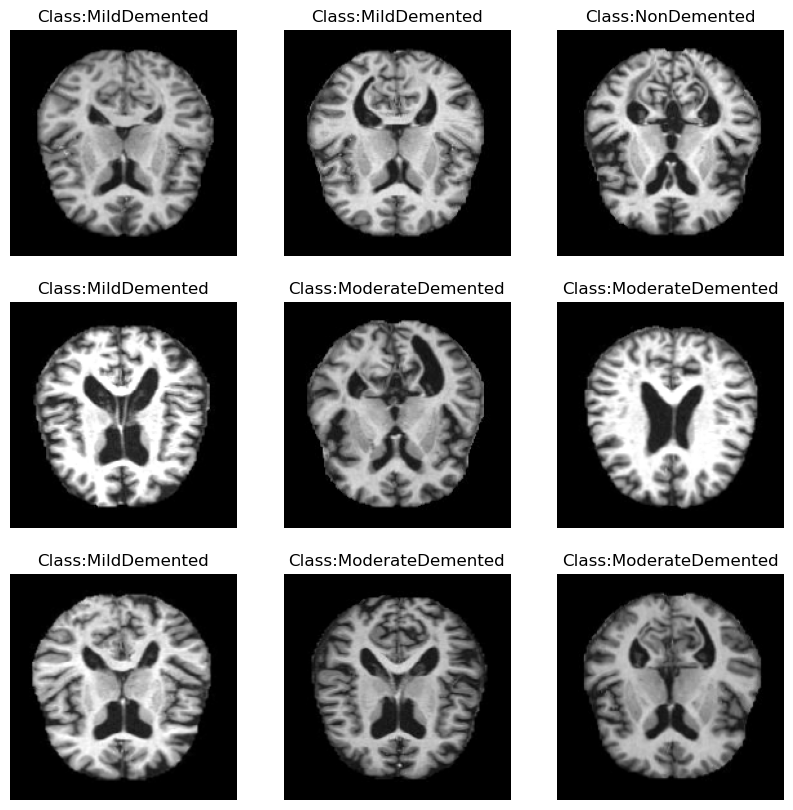

In [5]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [6]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [7]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [8]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [9]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [10]:
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [11]:
def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [12]:
def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

    return model

In [13]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [14]:
#Defining other parameters for our CNN model

model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()




Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 16)        0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 44, 44, 32)        14016     
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        55680     
                                                                 
 sequential_2 (Sequential)   (None, 11, 11, 128)       221952    
                                                      

In [15]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 100

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/100

256/256 [==============================] - 229s 844ms/step - loss: 1.6311 - acc: 0.3152 - auc: 0.5769 - f1_score: 0.3126 - val_loss: 1.4707 - val_acc: 0.2925 - val_auc: 0.5549 - val_f1_score: 0.2314
Epoch 2/100
256/256 [==============================] - 458s 2s/step - loss: 1.1020 - acc: 0.5002 - auc: 0.7789 - f1_score: 0.4867 - val_loss: 4.3256 - val_acc: 0.2573 - val_auc: 0.5655 - val_f1_score: 0.1033
Epoch 3/100
256/256 [==============================] - 128s 501ms/step - loss: 0.8264 - acc: 0.6226 - auc: 0.8750 - f1_score: 0.6151 - val_loss: 3.6994 - val_acc: 0.2495 - val_auc: 0.5140 - val_f1_score: 0.1324
Epoch 4/100
256/256 [==============================] - 2036s 8s/step - loss: 0.7230 - acc: 0.6602 - auc: 0.9023 - f1_score: 0.6540 - val_loss: 1.1229 - val_acc: 0.5068 - val_auc: 0.7844 - val_f1_score: 0.5107
Epoch 5/100
256/256 [==============================] - 122s 477ms/step - loss: 0.6602 - acc: 0.6968 - auc: 0.9184 - f1_score: 0.6933 - val_loss: 0.9226 - val_ac

Epoch 39/100
256/256 [==============================] - 214s 835ms/step - loss: 0.0443 - acc: 0.9863 - auc: 0.9992 - f1_score: 0.9863 - val_loss: 0.2334 - val_acc: 0.9346 - val_auc: 0.9887 - val_f1_score: 0.9350
Epoch 40/100
256/256 [==============================] - 215s 839ms/step - loss: 0.0645 - acc: 0.9799 - auc: 0.9983 - f1_score: 0.9799 - val_loss: 0.2849 - val_acc: 0.9165 - val_auc: 0.9848 - val_f1_score: 0.9151
Epoch 41/100
256/256 [==============================] - 217s 847ms/step - loss: 0.0463 - acc: 0.9856 - auc: 0.9990 - f1_score: 0.9856 - val_loss: 0.3116 - val_acc: 0.9189 - val_auc: 0.9835 - val_f1_score: 0.9177
Epoch 42/100
256/256 [==============================] - 217s 848ms/step - loss: 0.0637 - acc: 0.9796 - auc: 0.9983 - f1_score: 0.9796 - val_loss: 0.5621 - val_acc: 0.8457 - val_auc: 0.9659 - val_f1_score: 0.8357
Epoch 43/100
256/256 [==============================] - 217s 850ms/step - loss: 0.0497 - acc: 0.9830 - auc: 0.9990 - f1_score: 0.9830 - val_loss: 0.2384

Epoch 78/100
256/256 [==============================] - 136s 530ms/step - loss: 0.0312 - acc: 0.9912 - auc: 0.9991 - f1_score: 0.9912 - val_loss: 0.5828 - val_acc: 0.8628 - val_auc: 0.9629 - val_f1_score: 0.8571
Epoch 79/100
256/256 [==============================] - 129s 503ms/step - loss: 0.0314 - acc: 0.9915 - auc: 0.9995 - f1_score: 0.9915 - val_loss: 0.2436 - val_acc: 0.9419 - val_auc: 0.9854 - val_f1_score: 0.9417
Epoch 80/100
256/256 [==============================] - 129s 503ms/step - loss: 0.0193 - acc: 0.9935 - auc: 0.9995 - f1_score: 0.9935 - val_loss: 0.4003 - val_acc: 0.8960 - val_auc: 0.9764 - val_f1_score: 0.8944
Epoch 81/100
256/256 [==============================] - 130s 507ms/step - loss: 0.0205 - acc: 0.9934 - auc: 0.9996 - f1_score: 0.9934 - val_loss: 0.2720 - val_acc: 0.9370 - val_auc: 0.9835 - val_f1_score: 0.9367
Epoch 82/100
256/256 [==============================] - 129s 505ms/step - loss: 0.0230 - acc: 0.9926 - auc: 0.9997 - f1_score: 0.9926 - val_loss: 0.3566

In [16]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 12s 150ms/step - loss: 0.2373 - acc: 0.9484 - auc: 0.9864 - f1_score: 0.9489
Testing Accuracy: 94.84%


In [17]:
#Predicting the test data

pred_labels = model.predict(test_data)

80/80 [==============================] - 12s 144ms/step


In [18]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.99      0.96      0.98       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.92      0.90      0.91       662
ModerateDemented       0.88      0.93      0.90       624

       micro avg       0.95      0.95      0.95      2560
       macro avg       0.95      0.95      0.95      2560
    weighted avg       0.95      0.95      0.95      2560
     samples avg       0.95      0.95      0.95      2560



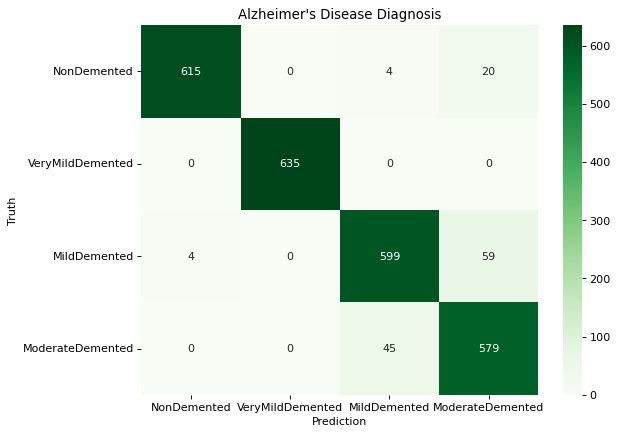

In [19]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [20]:
#Printing some other classification metrics

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 94.88 %
Matthew's Correlation Coefficient: 93.14 %


In [32]:
#Saving the model for future use

model_dir = work_dir + "alzheimer_cnn_model"
model.save(model_dir, save_format='h5')
os.listdir(work_dir)

['alzheimer_cnn_model',
 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented']

In [6]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np

from tensorflow_addons.metrics import F1Score

CLASSES = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# Load your custom Inception model
custom_inception_model = keras.models.load_model(r'C:\Users\jbaby\documents\Final_yr_pro\Practice\Alzi\dataset\alzheimer_cnn_model', 
                                                 custom_objects={'F1Score': F1Score})

# Load and preprocess the input image
img_path = r"C:\Users\jbaby\documents\Final_yr_pro\Fixed\Alzi_MRI_model\Data\MildDemented\MildDemented_24.jpg"
img = image.load_img(img_path, target_size=(176, 176))  # Resize to match model's input shape
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = custom_inception_model.predict(img_array)

# Get the top-4 predicted classes
top4_classes = np.argsort(predictions[0])[-4:][::-1]

# Print the top-4 predicted classes and their scores along with the class names
for i, class_index in enumerate(top4_classes):
    class_name = CLASSES[class_index]
    score = predictions[0][class_index]
    print(f"{i + 1}: {class_name} ({score:.2f})")


1/1 [==============================] - 1s 637ms/step
1: MildDemented (0.83)
2: ModerateDemented (0.15)
3: NonDemented (0.02)
4: VeryMildDemented (0.00)
